# Advanced Lane Finding
##  Camera Calibration


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

Success: Calibrated camera.


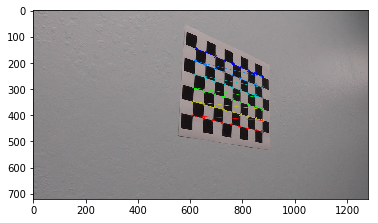

In [11]:
# prepare object points
nx = 9# Number of inside corners in x
ny = 6# Number of inside corners in y

# Make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")
# Create empty list of objPoints
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

for filename in images:

    img = cv2.imread(filename)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print('Success: Calibrated camera.')

##  Undistort an image

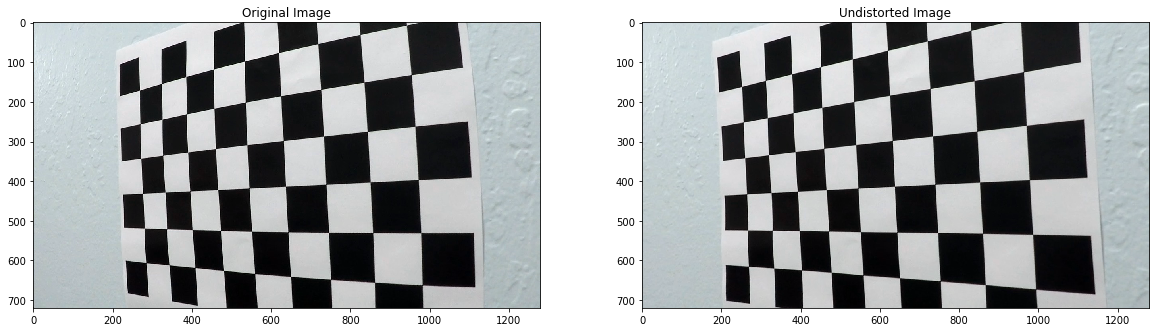

In [12]:

def undistort(img_, mtx_, dist_):
    return cv2.undistort(img_, mtx_, dist_, None, mtx_)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration4.jpg')
img_undistort = undistort(img,mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image')

## Create a thresholded binary image

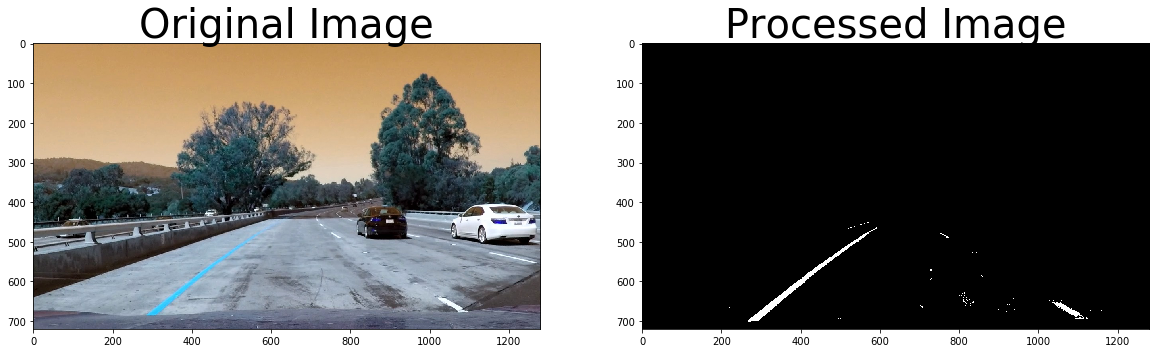

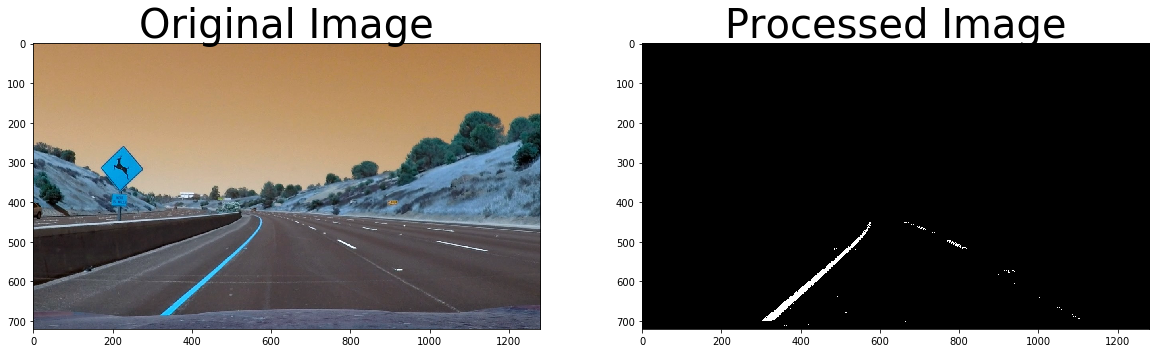

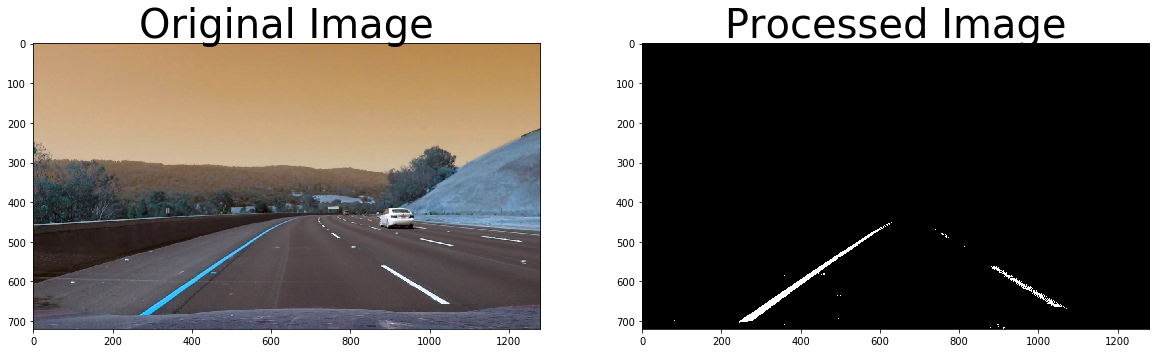

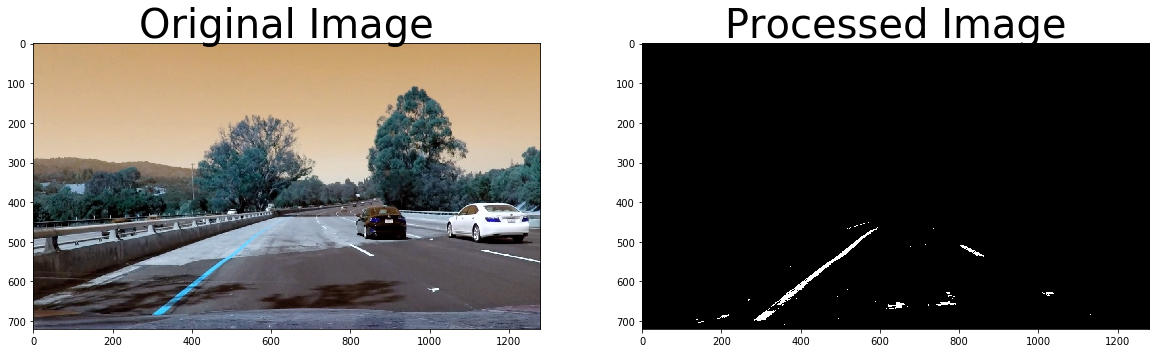

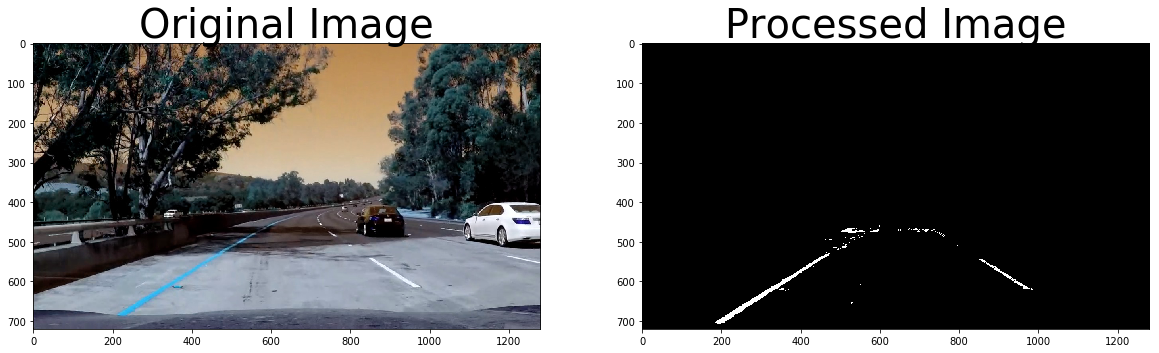

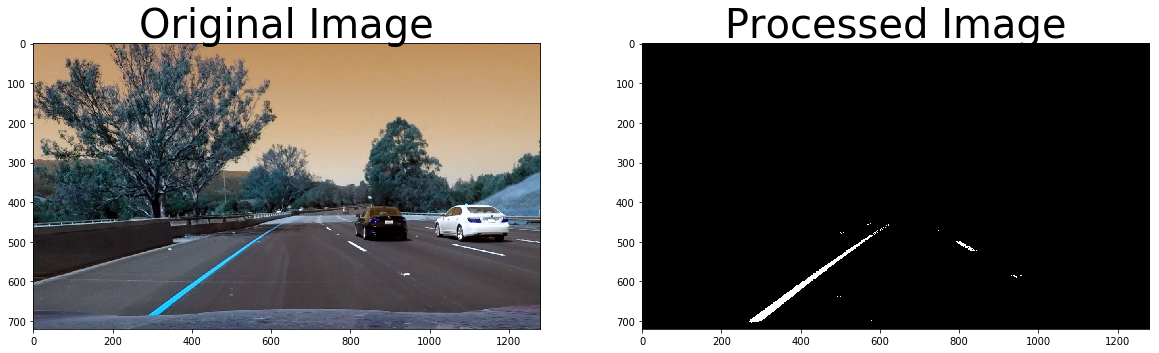

In [13]:

# Defind a function that takes image and kernel size
def apply_thresholds(image, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(150, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(70, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.1, 1.5))

    # Combine thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined


def apply_threshold_v2(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    # Grayscale image
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    # Threshold color channel

    # Convert to HLS color space and separate the L & S channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
  
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
# A pipeline for creating a thresholded binary image inside region of interest
combined_binary = 0
def binary_pipeline(raw_image):
    image = cv2.undistort(raw_image, mtx, dist, None, mtx)
    imshape = raw_image.shape

    height = raw_image.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw_image.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51
    horizontal_offset = 40

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)

    combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
    
  
    vertices = np.array([[(0,imshape[0]),(550, 450), (700, 450), (imshape[1],imshape[0])]], dtype=np.int32)
    combined_binary_region_of_interest = region_of_interest(combined_binary,vertices)
    return combined_binary_region_of_interest

for i in range(1,7):
    raw = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(raw)
    binary = binary_pipeline(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax2.imshow(binary, cmap="gray")
    ax2.set_title('Processed Image', fontsize=40)

- img_size:  (1280, 720)
- src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
- dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])



## Unwrap image and generate bird eye view

image shape: (720, 1280, 3)
image size: (1280, 720)


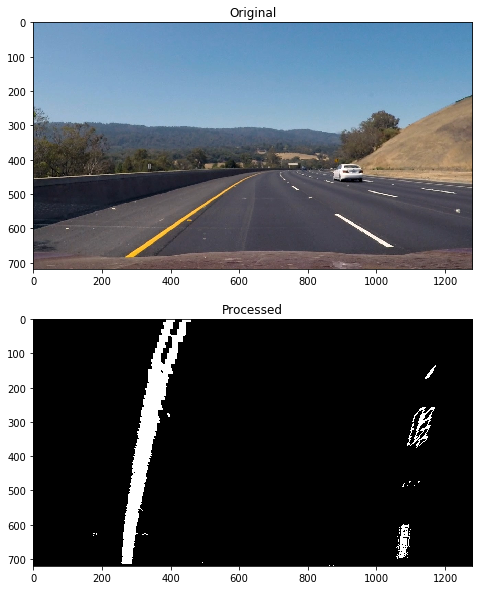

In [14]:
# Define image shape
image_shape = image.shape
img_size = (gray.shape[1], gray.shape[0])
print("image shape: {}".format(image_shape))
print("image size: {}".format(img_size))



undist = cv2.undistort(img, mtx, dist, None, mtx)
src = np.float32(
        [[580, 460],
         [710, 460],
         [1150, 720],
         [150, 720]])

dst = np.float32(
        [[200,0],
         [1080,0],
         [1080,720],
         [200,720]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()


# Example
example_image = mpimg.imread('test_images/test3.jpg')
warped = cv2.warpPerspective(binary_pipeline(example_image), M, img_size)

# Plotting transformed image
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.set_title('Original')
ax1.imshow(example_image)


ax2.set_title('Processed')
ax2.imshow(warped, cmap="gray")



## Finding the lines

In [17]:
def histogram_pixels(warped_thresholded_image, offset=50, steps=6,
                     window_radius=200, medianfilt_kernel_size=51,
                     horizontal_offset=50):
    # Initialise arrays
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    # Parameters
    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    width = warped_thresholded_image.shape[1]
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps

    for step in range(steps):
        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

        # Define the window (horizontal slice)
        window_start_y = height - (step * pixels_per_step) + offset
        window_end_y = window_start_y - pixels_per_step + offset

        # Take a count of all the pixels at each x-value in the horizontal slice
        histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y), int(horizontal_offset):int(width - horizontal_offset)], axis=0)
        # plt.plot(histogram)

        # Smoothen the histogram
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        # plt.plot(histogram_smooth)

        # Identify the left and right peaks
        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)

        # Add coordinates to window centres

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        # Get pixels in the left window
        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
                                                                       y_centre, window_radius)
            # plt.scatter(left_x_additional, left_y_additional)
            # Add pixels to list
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        # Get pixels in the right window
        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                         y_centre, window_radius)
            # plt.scatter(right_x_additional, right_y_additional)
            # Add pixels to list
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)

    if len(right_x) == 0 or len(left_x) == 0:
        print("Init no peaks for left or right")
        print("left_x: ", left_x)
        print("right_x: ", right_x)

        horizontal_offset = 0

        left_x = []
        left_y = []
        right_x = []
        right_y = []

        for step in range(steps):
            left_x_window_centres = []
            right_x_window_centres = []
            y_window_centres = []

            # Define the window (horizontal slice)
            window_start_y = height - (step * pixels_per_step) + offset
            window_end_y = window_start_y - pixels_per_step + offset

            # Take a count of all the pixels at each x-value in the horizontal slice
            histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y),
                               int(horizontal_offset):int(width - horizontal_offset)], axis=0)
            # plt.plot(histogram)

            # Smoothen the histogram
            histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

            # plt.plot(histogram_smooth)

            # Identify the left and right peaks
            left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
            right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
            if len(left_peaks) > 0:
                left_peak = max(left_peaks)
                left_x_window_centres.append(left_peak)

            if len(right_peaks) > 0:
                right_peak = max(right_peaks) + half_frame
                right_x_window_centres.append(right_peak)

            # Add coordinates to window centres

            if len(left_peaks) > 0 or len(right_peaks) > 0:
                y_window_centres.append((window_start_y + window_end_y) // 2)

            # Get pixels in the left window
            for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
                left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
                                                                           y_centre, window_radius)
                # plt.scatter(left_x_additional, left_y_additional)
                # Add pixels to list
                left_x.append(left_x_additional)
                left_y.append(left_y_additional)

            # Get pixels in the right window
            for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
                right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                             y_centre, window_radius)
                # plt.scatter(right_x_additional, right_y_additional)
                # Add pixels to list
                right_x.append(right_x_additional)
                right_y.append(right_y_additional)

    return collapse_into_single_arrays(left_x, left_y, right_x, right_y)



In [19]:
def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y



In [21]:
def collapse_into_single_arrays(leftx, lefty, rightx, righty):
    leftx = [x
             for array in leftx
             for x in array]
    lefty = [x
             for array in lefty
             for x in array]
    rightx = [x
              for array in rightx
              for x in array]
    righty = [x
              for array in righty
              for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty

In [23]:
def fit_second_order_poly(indep, dep, return_coeffs=False):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit
    else:
        return fitdep

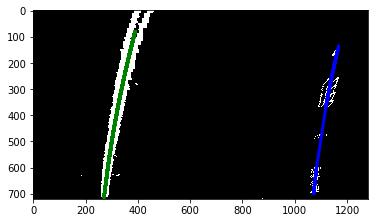

In [24]:
from scipy import signal

# Histogram and get pixels in window

leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

# Draw the line alongside the traffic lane
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)

# Plot data
plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='blue', linewidth=3)
plt.imshow(warped, cmap="gray")


In [26]:
def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

In [28]:
def lane_poly(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

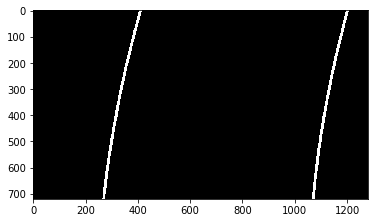

In [29]:
# Draw a black canvas with detected lanes
black_canvas=np.zeros((720, 1280))
polyfit_left = draw_poly(np.zeros((720, 1280)), lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

In [31]:
def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

In [33]:
def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

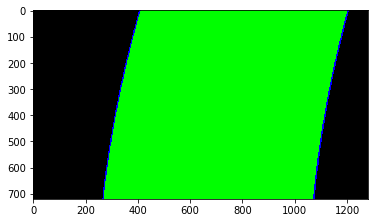

In [34]:
# Highlight the area within the detected lanes

trace = cv2.cvtColor(black_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(black_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

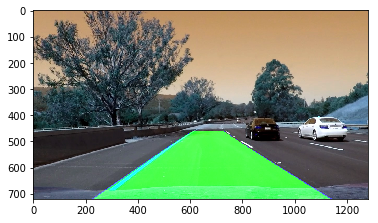

In [35]:
# Put them together
lane_lines = cv2.warpPerspective(trace, Minv, (1280, 720), flags=cv2.INTER_LINEAR)
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

### Finding Curves

In [36]:
# Measuring Curvature
yvals = np.linspace(0, 100, num=101)*7.2 
y_eval = np.max(yvals)
curvature = 0
min_curvature = 0
def center(y, left_poly, right_poly):
    center = (1.5 * evaluate_poly(y, left_poly)
              - evaluate_poly(y, right_poly)) / 2
    return center


left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)
print("y_eval: {}".format(y_eval))
print("Left lane curve radius: {} pixels".format(left_curverad))
print("Right lane curve radius:{} pixels".format(right_curverad))
print("Center:{} pixels".format(centre))


y_eval: 720.0
Left lane curve radius: 4205.356798840068 pixels
Right lane curve radius:4098.157970414237 pixels
Center:-332.4858008075671 pixels


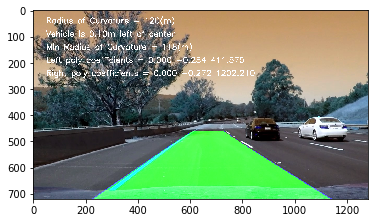

In [37]:
def add_figures_to_image(img, curvature, vehicle_position, min_curvature, left_coeffs=(0,0,0), right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)

add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.imshow(combined_img)

## Put them all together as a pipeline

## Generate video output

In [ ]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) 
%time output_clip.write_videofile(output, audio=False)